# Dimensionality reduction through Linear Discriminant Analysis

Linear discriminant analysis can be stated as a dimensionality reduction task – find a hyperplane such that points from different classes are maximally separated. The latter can be quantified in two principal ways:

* as a signal-to-noise ratio from signal-processing
* as Bayesian factors from statistics

Both formalisations lead to the equivalent maximisation tasks. 
In this tutorial we do not consider technical details of the LDA transformation, rather we give a visual interpretation to it and explore the connections between LDA and PCA. 
Recall that PCA can be viewed as a dimensionality reduction task with a different objective – find a hyperplane such that all points are maximally separated. 
These tasks are weakly connected. A maximal separation between classes cannot bring all points together but at the same time it does not have to spread them apart inside a single class. 

To explore dimensionality reduction through LDA, we need a high-dimensional dataset with labels. 
We will use an image with different textures and colors such that local textures are strongly connected with different colors.
Therefore, if we split the color space into separate clusters, we get the desired labels for the textures.
The correspondence between image points and local textures allows us to map the LDA dimensions back to the pixels and use various color channels to show their values. This makes it possible to interpret what different LDA dimensions characterise.    

Since the color space is inherently three-dimensional, we use the package `ipyvolume` for making three-dimensional plots interactive. Further details about this package can be obtained from

* [Ipyvolume documentation](https://ipyvolume.readthedocs.io/en/latest/)
* [Maarten Breddels, Interactive 3D Visualization in Jupyter, SciPy 2018, Youtube](https://www.youtube.com/watch?v=hOKa8klJPyo)
* [Maarten Breddels, Interactive 3D Visualization in Jupyter, SciPy 2018, Jupyter Notebook](https://github.com/maartenbreddels/talk-ipyvolume-scipy2018/blob/master/ipyvolume-presentation.ipynb)


We use several functions defined in [`common.py`](./common.py) to juggle between different image representations:

* luminocity decomposition
* conversions between the standard RGB image and color space representation 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn

# Tools for 3D visualisation
import ipyvolume as ipv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle

# Tools for LDA and PCA
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Tools for clustering
from sklearn.cluster import KMeans

# Standard stuff
from pandas import Series
from pandas import DataFrame
from tqdm import tnrange#, tqdm_notebook
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Color-based classification of pixels 

We load the image and annotate each pixel with a color class.   

### Initial image

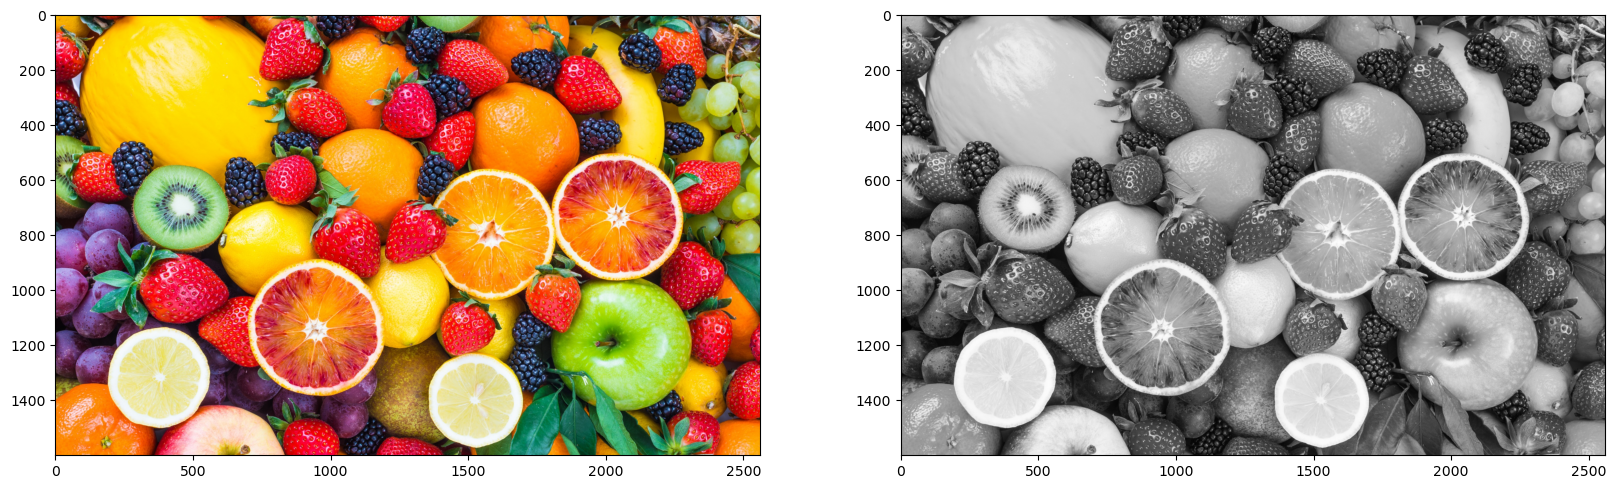

In [2]:
rgb_image = plt.imread('data/texture/colorful_fruits.png')
bw_image = convert_to_grayscale(rgb_image)

fig=plt.figure(figsize=(20,10))
fig.add_subplot(1, 2, 1)
plt.imshow(rgb_image)
fig.add_subplot(1, 2, 2)
plt.imshow(bw_image, cmap='gray')

### Color space representation

In [3]:
full_cs = image_to_colorspace(rgb_image)
sample_cs = image_to_colorspace(rgb_image, sample_count=10000)

In [4]:
show_colorspace(sample_cs, clip=False)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

### Luma decomposition

Luma decomposition adds `luma`, `rR`, `rG`, `rB` to the color space so that RGB information is decomposed into luminocity and chroma information. For simplicity the chroma information is stored as a three-dimensional vector `rR`, `rG`, `rB`. The corresponfing formula is

\begin{align*}
RGB = luma \cdot rRGB\,.
\end{align*}

In [5]:
full_cs = luma_decomposition(full_cs)
sample_cs = luma_decomposition(sample_cs)
display(head(full_cs))
show_colorspace(sample_cs[['rR', 'rG', 'rB']].rename(columns = {'rR': 'R', 'rG': 'G', 'rB': 'B'}))

R         G         B      luma        rR        rG        rB
0  1.000000  0.768627  0.027451  0.753214  1.327644  1.020464  0.036445
1  1.000000  0.760784  0.019608  0.747716  1.337407  1.017478  0.026224
2  0.988235  0.752941  0.000000  0.737360  1.340235  1.021131  0.000000
3  0.976471  0.741176  0.000000  0.726938  1.343266  1.019587  0.000000
4  0.976471  0.749020  0.000000  0.731542  1.334812  1.023892  0.000000

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

### Color space clustering with k-means algorithm

We will use a relatively small sample to define color clusters and then extend corresponding labelling to the entire set of pixels.

In [6]:
kmeans = KMeans(n_clusters=16).fit(sample_cs[['R', 'G', 'B']])
centers = DataFrame(kmeans.cluster_centers_, columns = ['R', 'G', 'B'])
full_cs = full_cs.assign(label = lambda df: kmeans.predict(df[['R', 'G', 'B']]))[['label', 'R', 'G', 'B', 'luma', 'rR', 'rG', 'rB']]
head(full_cs)

label         R         G         B      luma        rR        rG        rB
0      7  1.000000  0.768627  0.027451  0.753214  1.327644  1.020464  0.036445
1      7  1.000000  0.760784  0.019608  0.747716  1.337407  1.017478  0.026224
2      7  0.988235  0.752941  0.000000  0.737360  1.340235  1.021131  0.000000
3      7  0.976471  0.741176  0.000000  0.726938  1.343266  1.019587  0.000000
4      7  0.976471  0.749020  0.000000  0.731542  1.334812  1.023892  0.000000

In [7]:
centers

R         G         B
0   0.605514  0.721964  0.153571
1   0.643944  0.821842  0.528262
2   0.163161  0.119337  0.092587
3   0.867919  0.360076  0.047968
4   0.974137  0.578774  0.032390
5   0.893673  0.053563  0.096326
6   0.209512  0.517242  0.408051
7   0.988892  0.811675  0.048068
8   0.957766  0.878231  0.558292
9   0.594922  0.091248  0.052372
10  0.300330  0.220467  0.326206
11  0.903544  0.252430  0.285834
12  0.451798  0.378274  0.071301
13  0.941548  0.906078  0.861430
14  0.958319  0.566878  0.432605
15  0.540333  0.463354  0.697227

## II. Visual evaluation of clustering quality

* We first compute the mean chroma value for each cluster. 
* Next we transfer color classes to each pixel of a black and white image.
* After that we add the chroma value corresponding to the cluster label to the black and white image.
* As the resulting data structure now has luma-chroma representation we can reconstruct the RGB representation.  

### Chroma values for each color cluster

In [8]:
chromas = (sample_cs
           .assign(label = lambda df: kmeans.predict(df[['R', 'G', 'B']]))
           .groupby('label')
           .aggregate({'rR': 'mean', 'rG': 'mean', 'rB': 'mean'})
           .reset_index())

display(chromas)

label        rR        rG        rB
0       0  0.978103  1.156964  0.250062
1       1  0.874308  1.118134  0.722143
2       2  1.316622  0.876004  0.809187
3       3  1.835888  0.749044  0.101438
4       4  1.541198  0.908982  0.050557
5       5  2.921991  0.155916  0.307845
6       6  0.485661  1.260393  1.008641
7       7  1.274864  1.042719  0.060240
8       8  1.107918  1.014091  0.645366
9       9  2.592040  0.340135  0.224384
10     10  1.171903  0.855518  1.294115
11     11  2.028513  0.546295  0.640369
12     12  1.251411  1.029501  0.189790
13     13  1.034853  0.993115  0.944946
14     14  1.445497  0.840542  0.653883
15     15  1.069926  0.892387  1.371649

Visual comparison of cluster centers and chroma values. For clarity we scale the luminocity of chroma values to maximal intensity.

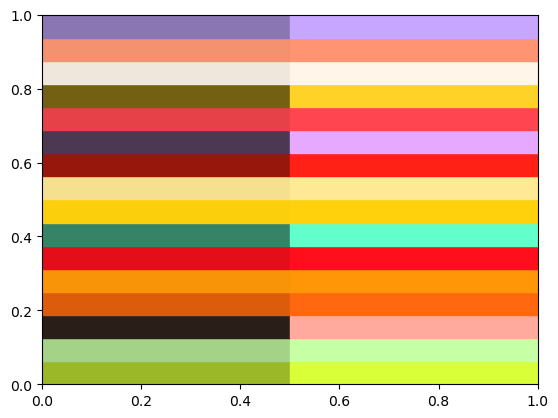

In [9]:
tmp = (chromas[['rR', 'rG', 'rB']]
       .assign(max = lambda df: df.apply(max, axis = 'columns'))
       .assign(rR = lambda df: df['rR']/df['max'])
       .assign(rG = lambda df: df['rG']/df['max'])
       .assign(rB = lambda df: df['rB']/df['max'])
       [['rR', 'rG', 'rB']]
      )

plt.figure()
currentAxis = plt.gca()
n = len(centers)
for i in range(n):
    currentAxis.add_patch(Rectangle((0,   i/n), 0.5, 1/n,alpha=1, color=centers.loc[i,:]))
    currentAxis.add_patch(Rectangle((0.5, i/n), 0.5, 1/n,alpha=1, color=tmp.loc[i,:]))
plt.show()

### Label transfer to black and white image pixels

As we merge the black and white data frame with chroma values we need to store the original order or it would be lost and we would not be able to get the image back.

In [10]:
bw_cspace = (DataFrame(bw_image.flatten(), columns = ['luma'])
             .assign(i = lambda df: df.index.values)
             .assign(label = full_cs['label'])
             [['i', 'label', 'luma']])

head(bw_cspace)

i  label      luma
0  0      7  0.753214
1  1      7  0.747716
2  2      7  0.737360
3  3      7  0.726938
4  4      7  0.731542

### Chroma transfer to black and white image pixels and image reconstruction

In [11]:
bw_cspace = pd.merge(bw_cspace, chromas, on = 'label').set_index('i').sort_index()
bw_cspace = rgb_reconstruction(bw_cspace)
head(bw_cspace)

label      luma        rR        rG       rB         R         G         B
i                                                                            
0      7  0.753214  1.274864  1.042719  0.06024  0.960245  0.785390  0.045374
1      7  0.747716  1.274864  1.042719  0.06024  0.953236  0.779657  0.045043
2      7  0.737360  1.274864  1.042719  0.06024  0.940034  0.768859  0.044419
3      7  0.726938  1.274864  1.042719  0.06024  0.926747  0.757991  0.043791
4      7  0.731542  1.274864  1.042719  0.06024  0.932616  0.762792  0.044068

### Visual validation of classification quality 

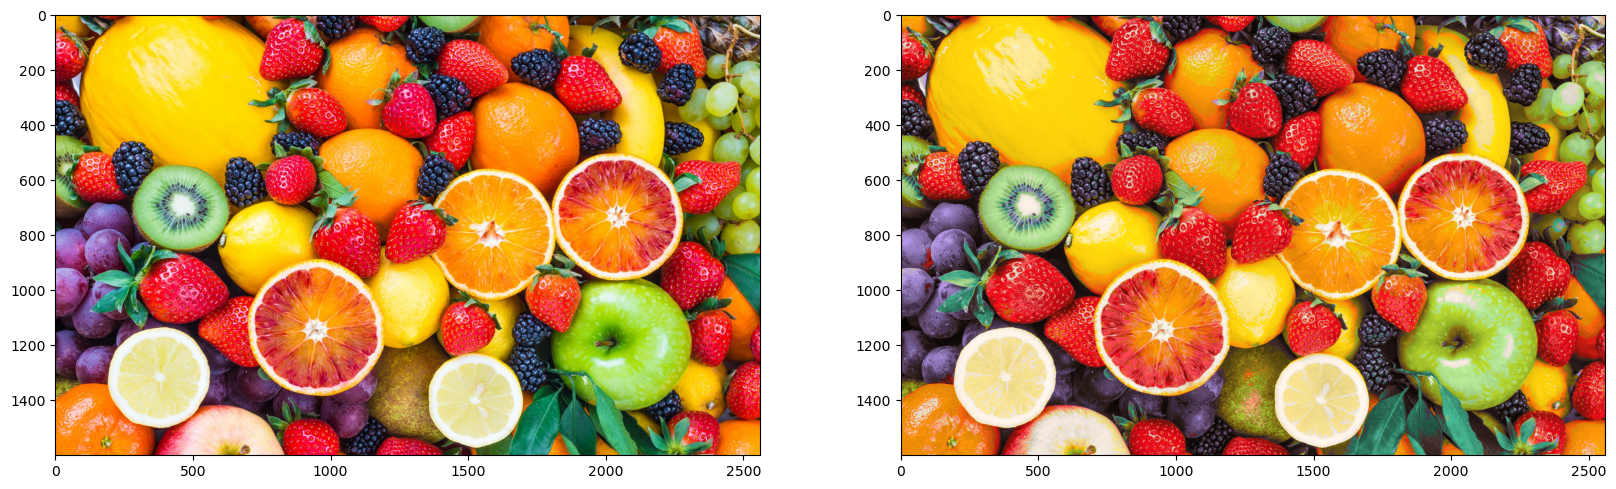

In [12]:
m, n = bw_image.shape
fig=plt.figure(figsize=(20,10))
fig.add_subplot(1, 2, 1)
plt.imshow(rgb_image)
fig.add_subplot(1, 2, 2)
plt.imshow(np.clip(colorspace_to_image(bw_cspace, m, n), 0,1))

## III. Preparations for linear discriminant analysis

Let's first fix the important parameters about the image:
* image size $m\times n$
* texture window size $(2d+1)\times (2d+1)$
* size of the patch grid $k\times \ell$

In [13]:
d = 7
m, n = dim(bw_image)
k = int(m/(2 * d + 1))
l = int(n/(2 * d + 1))

### Grid of labels

Let's arrange the class labels for individual pixels into an $m\times n$ grid for simplicity. 

In [14]:
head(bw_cspace)

label      luma        rR        rG       rB         R         G         B
i                                                                            
0      7  0.753214  1.274864  1.042719  0.06024  0.960245  0.785390  0.045374
1      7  0.747716  1.274864  1.042719  0.06024  0.953236  0.779657  0.045043
2      7  0.737360  1.274864  1.042719  0.06024  0.940034  0.768859  0.044419
3      7  0.726938  1.274864  1.042719  0.06024  0.926747  0.757991  0.043791
4      7  0.731542  1.274864  1.042719  0.06024  0.932616  0.762792  0.044068

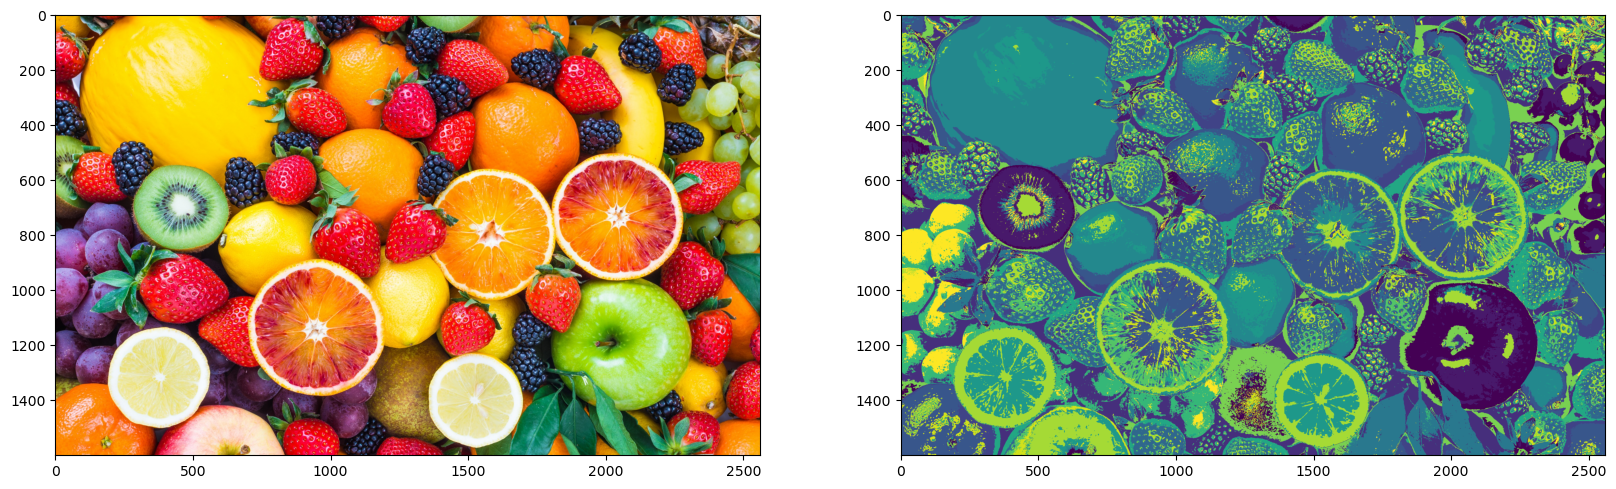

In [15]:
label_grid = bw_cspace['label'].values.reshape(m, n)

fig=plt.figure(figsize=(20,10))
fig.add_subplot(1, 2, 1)
plt.imshow(rgb_image)
fig.add_subplot(1, 2, 2)
plt.imshow(label_grid)

### Extraction of texture windows with corresponding labels

For every coordinate $(x,y)$ we extract a $(2d+1)\times(2d+1)$ window centered in $(x,y)$ and having the label `label_grid[x,y]`.
For simplicity, we ignore all coordinates where one of the following conditions is satisfied:

\begin{align*}
&\begin{aligned}
x&< d\,,\\
x&\geq m-d\,,
\end{aligned}
&
&\begin{aligned}
y&< d\,,\\
y&\geq n-d\,.
\end{aligned}
\end{align*}


In [16]:
def extract_texture_vectors(bw_image: np.array, label_grid: np.array, x: np.array, y:np.array, m: int, n: int, d: int) -> DataFrame:
    
    index = (d <= x) & (x < m - d) & (d <= y) & (y < n - d)
    xm = x[index]
    ym = y[index]
    
    x0 = xm - d
    x1 = xm + d + 1
    y0 = ym - d
    y1 = ym + d + 1
    
    r = len(xm)
    texture_labels = np.empty([r])
    textures = np.empty([r, (2 * d + 1)**2])
    for i in range(r):
        texture_labels[i] = label_grid[xm[i], ym[i]]
        textures[i, :] = bw_image[x0[i]:x1[i], y0[i]:y1[i]].flatten()
        
    columns = ['x{:02d}'.format(i+1) for i in range((2*d+1)**2)]   
    return (DataFrame(textures, columns = columns)
            .assign(label = Series(texture_labels).astype(int))
            .assign(xm = Series(xm).astype(int))
            .assign(ym = Series(ym).astype(int))
            [['label', 'xm', 'ym'] + columns])

Simple test that the function works as expected.

In [17]:
d1 = 1
x =np.array([0,7,8, 1595])
y = x 
index = (d1 <= x) & (x < m - d1) & (d1 <= y) & (y < n - d1)
tmp = extract_texture_vectors(bw_image, label_grid, x, y, m, n , d=d1)
mdisplay([DataFrame(label_grid[x[index],y[index]], columns=['label']), tmp, DataFrame(bw_image[x[index], y[index]], columns = ['luma'])], ['labels', 'textures', 'midpoints'])

labels textures midpoints 
 
 
 label 
 
 
 
 
 7 
 
 
 7 
 
 
 12 
 
 
 
 
 
 label 
 xm 
 ym 
 x01 
 x02 
 x03 
 x04 
 x05 
 x06 
 x07 
 x08 
 x09 
 
 
 
 
 7 
 7 
 7 
 0.744073 
 0.737402 
 0.737402 
 0.744073 
 0.741324 
 0.744073 
 0.725850 
 0.722376 
 0.725850 
 
 
 7 
 8 
 8 
 0.741324 
 0.744073 
 0.739916 
 0.722376 
 0.725850 
 0.734140 
 0.726297 
 0.726297 
 0.730708 
 
 
 12 
 1595 
 1595 
 0.295183 
 0.295183 
 0.293775 
 0.299104 
 0.289854 
 0.286827 
 0.291262 
 0.274169 
 0.267221 
 
 
 
 
 
 luma 
 
 
 
 
 0.741324 
 
 
 0.725850 
 
 
 0.289854

The actual extraction of random texture windows. With small probability returns replicas of the same window. 

In [18]:
d = 7
r = 5000
x = np.random.choice(range(d, m - d), size=r, replace = True)
y = np.random.choice(range(d, n - d), size=r, replace = True)
df = extract_texture_vectors(bw_image, label_grid, x, y, m, n , d)
head(df)

label    xm    ym       x01       x02       x03       x04       x05  \
0      8  1428  1519  0.840689  0.855479  0.838858  0.830738  0.851364   
1      5   299    12  0.286713  0.314082  0.479907  0.630790  0.673433   
2      2  1316    40  0.192585  0.197636  0.189794  0.166267  0.146661   
3      5  1174   614  0.378018  0.384006  0.348286  0.325587  0.297322   
4      8  1520  1497  0.881693  0.882587  0.881693  0.885614  0.881735   

        x06       x07  ...      x216      x217      x218      x219      x220  \
0  0.855388  0.849950  ...  0.878092  0.854632  0.843424  0.850035  0.842639   
1  0.637182  0.521674  ...  0.435159  0.428235  0.416707  0.418284  0.422205   
2  0.146661  0.154504  ...  0.205147  0.204253  0.199438  0.204767  0.204767   
3  0.347035  0.388010  ...  0.482729  0.564270  0.650880  0.700363  0.685143   
4  0.883143  0.879222  ...  0.902422  0.910367  0.918589  0.920100  0.929730   

       x221      x222      x223      x224      x225  
0  0.851992  0.863755  0.865888  0.850035  0.841812  
1  0.422205  0.404007  0.419414  0.432434  0.431836  
2  0.196924  0.188635  0.185161  0.185161  0.179832  
3  0.579949  0.418939  0.349482  0.325248  0.306470  
4  0.936400  0.941451  0.928794  0.918438  0.910754  

[5 rows x 228 columns]

## IV. Linear discriminant analysis

Now that we have extracted the texture vectors with their locations and labels, we can use `sklearn` to do linear discriminant analysis. 

In [19]:
head(df.iloc[:, 3:])

x01       x02       x03       x04       x05       x06       x07  \
0  0.840689  0.855479  0.838858  0.830738  0.851364  0.855388  0.849950   
1  0.286713  0.314082  0.479907  0.630790  0.673433  0.637182  0.521674   
2  0.192585  0.197636  0.189794  0.166267  0.146661  0.146661  0.154504   
3  0.378018  0.384006  0.348286  0.325587  0.297322  0.347035  0.388010   
4  0.881693  0.882587  0.881693  0.885614  0.881735  0.883143  0.879222   

        x08       x09       x10  ...      x216      x217      x218      x219  \
0  0.870897  0.872147  0.863411  ...  0.878092  0.854632  0.843424  0.850035   
1  0.412576  0.320655  0.266477  ...  0.435159  0.428235  0.416707  0.418284   
2  0.145767  0.145767  0.141846  ...  0.205147  0.204253  0.199438  0.204767   
3  0.485120  0.479555  0.461846  ...  0.482729  0.564270  0.650880  0.700363   
4  0.875301  0.872957  0.877772  ...  0.902422  0.910367  0.918589  0.920100   

       x220      x221      x222      x223      x224      x225  
0  0.842639  0.851992  0.863755  0.865888  0.850035  0.841812  
1  0.422205  0.422205  0.404007  0.419414  0.432434  0.431836  
2  0.204767  0.196924  0.188635  0.185161  0.185161  0.179832  
3  0.685143  0.579949  0.418939  0.349482  0.325248  0.306470  
4  0.929730  0.936400  0.941451  0.928794  0.918438  0.910754  

[5 rows x 225 columns]

In [20]:
lda = LinearDiscriminantAnalysis()
lda.fit(df.iloc[:, 3:], df['label'])

LinearDiscriminantAnalysis()

In [21]:
head(DataFrame(lda.transform(df.iloc[:, 3:]), columns = ['xi{:02d}'.format(i) for i in range(15)]))

xi00      xi01      xi02      xi03      xi04      xi05      xi06  \
0 -5.516539  0.930128  0.126691 -0.051393 -0.385366  0.492860 -0.196466   
1  4.513348  3.046279  0.097761  1.240680 -0.509508  0.491932  1.506313   
2  7.031257 -0.156881  1.122981  0.156385 -0.804678 -0.065576 -0.507724   
3  4.679317  1.058654 -1.145743 -0.185021 -1.011195  0.781847 -0.829454   
4 -6.561943  0.826707  0.045449 -0.101630 -0.252791  0.125342  0.001490   

       xi07      xi08      xi09      xi10      xi11      xi12      xi13  \
0  0.546443 -0.121677  0.299368 -0.688990  0.555598 -0.420829 -0.081879   
1 -0.500170 -0.690025  0.808955  0.720302 -1.856115  0.494760  1.572878   
2  0.548404 -0.404592  0.027044  0.323568 -0.252498  0.072491  0.599943   
3 -0.077521 -1.025951 -0.047514  0.616696  1.444201  0.383917  1.566649   
4 -0.397675  0.335437  0.083482  0.136980  0.224438  0.242247  0.265201   

       xi14  
0 -0.102636  
1 -0.482342  
2 -0.073815  
3  0.993661  
4 -0.096351

In [22]:
XI = df.iloc[:, :3].join(DataFrame(lda.transform(df.iloc[:, 3:]), columns = ['xi{:02d}'.format(i) for i in range(15)]))
display(head(XI))

label    xm    ym      xi00      xi01      xi02      xi03      xi04  \
0      8  1428  1519 -5.516539  0.930128  0.126691 -0.051393 -0.385366   
1      5   299    12  4.513348  3.046279  0.097761  1.240680 -0.509508   
2      2  1316    40  7.031257 -0.156881  1.122981  0.156385 -0.804678   
3      5  1174   614  4.679317  1.058654 -1.145743 -0.185021 -1.011195   
4      8  1520  1497 -6.561943  0.826707  0.045449 -0.101630 -0.252791   

       xi05      xi06      xi07      xi08      xi09      xi10      xi11  \
0  0.492860 -0.196466  0.546443 -0.121677  0.299368 -0.688990  0.555598   
1  0.491932  1.506313 -0.500170 -0.690025  0.808955  0.720302 -1.856115   
2 -0.065576 -0.507724  0.548404 -0.404592  0.027044  0.323568 -0.252498   
3  0.781847 -0.829454 -0.077521 -1.025951 -0.047514  0.616696  1.444201   
4  0.125342  0.001490 -0.397675  0.335437  0.083482  0.136980  0.224438   

       xi12      xi13      xi14  
0 -0.420829 -0.081879 -0.102636  
1  0.494760  1.572878 -0.482342  
2  0.072491  0.599943 -0.073815  
3  0.383917  1.566649  0.993661  
4  0.242247  0.265201 -0.096351

### Corresponding visualisation

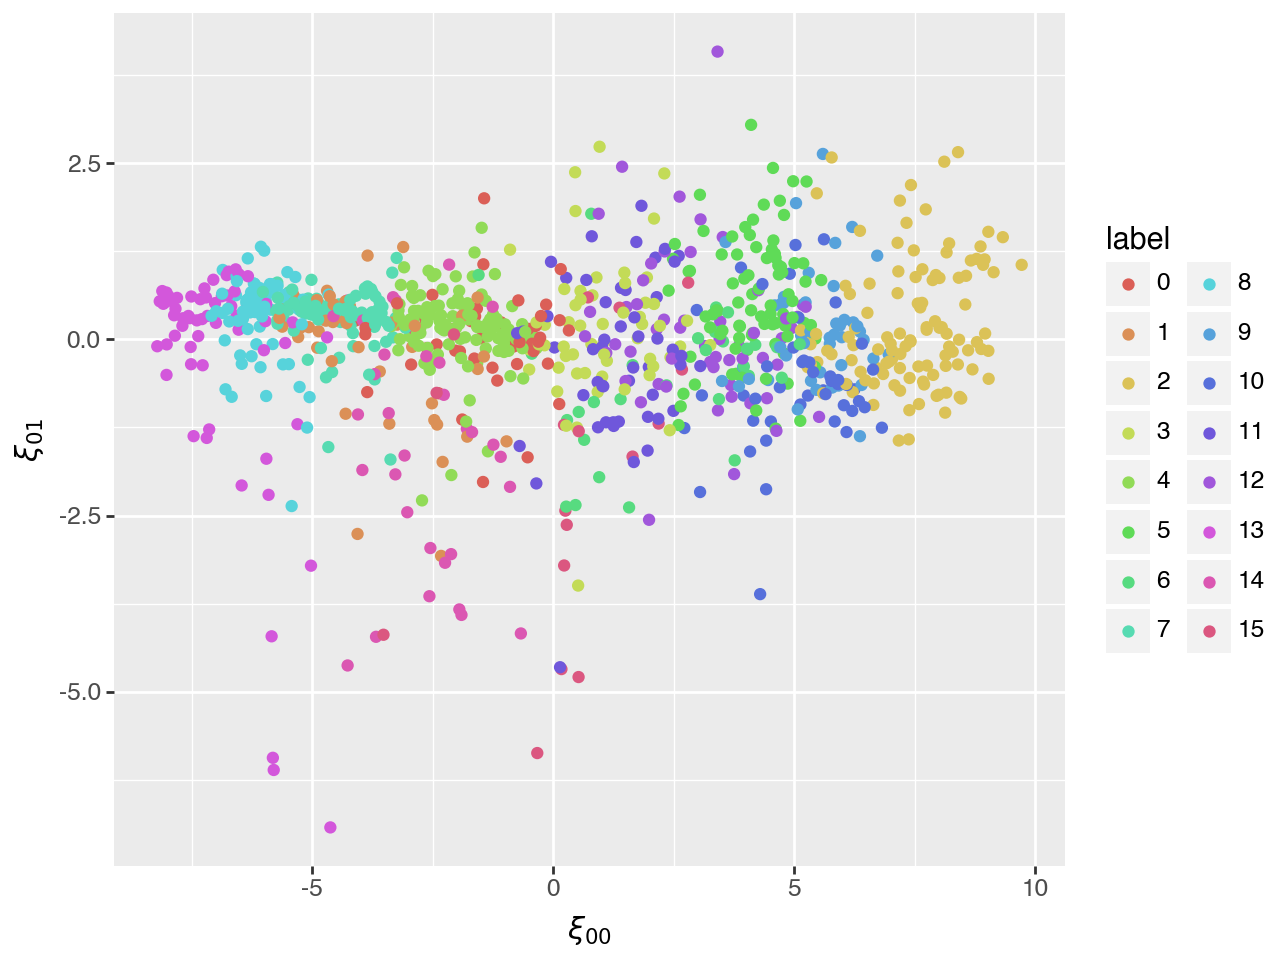

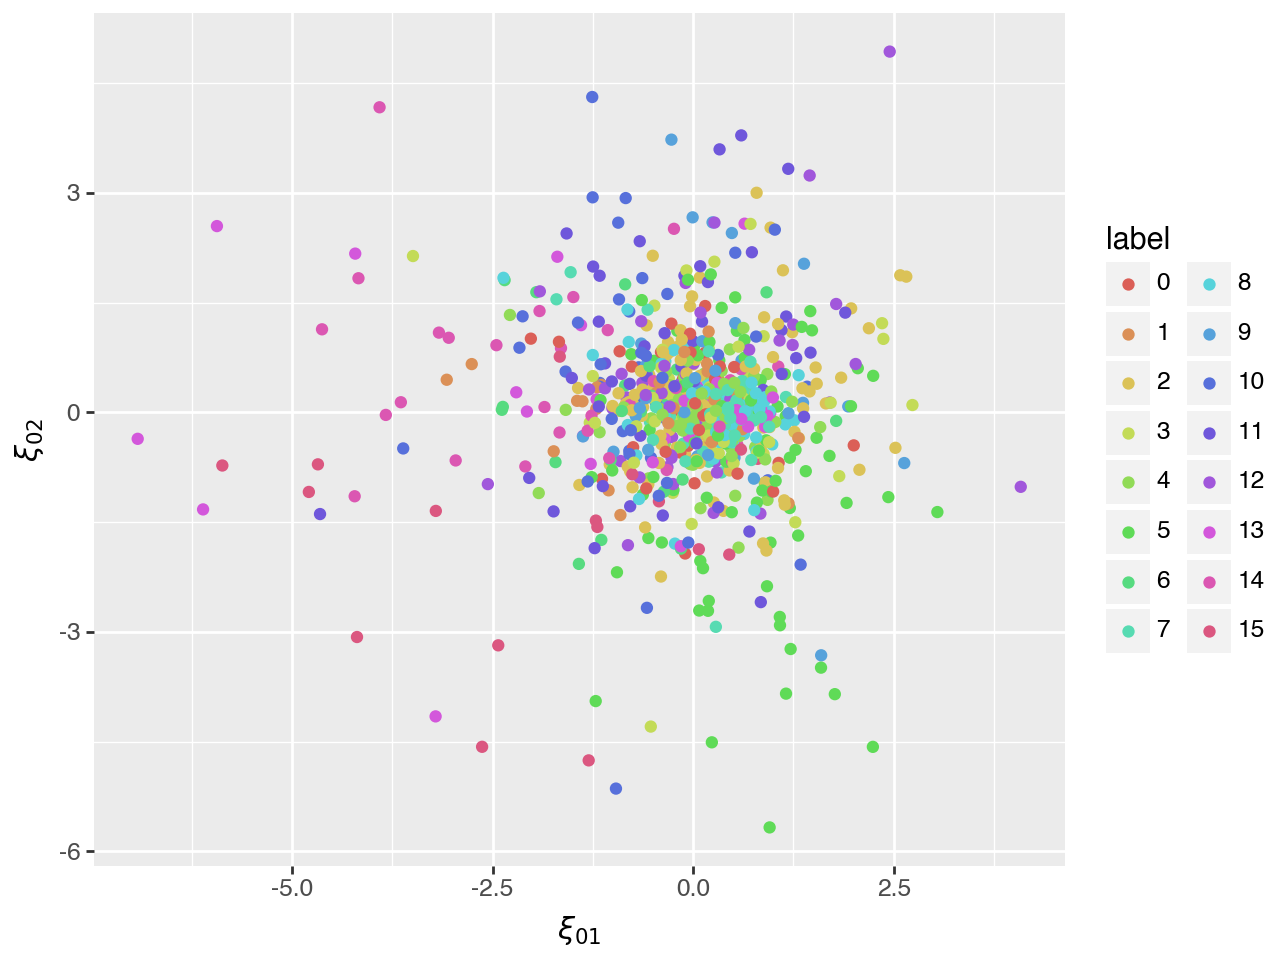

In [23]:
tmp = XI.sample(1000).assign(label = lambda df: df['label'].astype('category'))
p = ggplot(tmp)
p = p + geom_point(aes(x = 'xi00', y = 'xi01', color = 'label'))
p = p + scale_x_continuous(name = r'$\xi_{00}$')
p = p + scale_y_continuous(name = r'$\xi_{01}$')
display(p)
p = ggplot(tmp)
p = p + geom_point(aes(x = 'xi01', y = 'xi02', color = 'label'))
p = p + scale_x_continuous(name = r'$\xi_{01}$')
p = p + scale_y_continuous(name = r'$\xi_{02}$')
display(p)

### Projection directions as discriminative images

Let us first extract the matrix $\boldsymbol{\mathrm W}_{LDA}$ of orthogonal discriminative directions. Note that these are used to compute LDA projections

\begin{align*}
\boldsymbol{\xi} = \boldsymbol{\mathrm W}_{LDA} (\boldsymbol{x}_i-\boldsymbol{\mu})\,.
\end{align*}

The corresponding fields of the LDA object are `LDA.scalings_` and `LDA.xbar_`.
Note that class predictions can be computed through comparing score functions which can be expressed as

\begin{align*}
\boldsymbol{d} = \boldsymbol{\mathrm S}_{LDA}\boldsymbol{x} + \boldsymbol{s}_0
\end{align*}

where fields of the LDA object are `LDA.coef_` and `LDA.xbar_`. The point $\boldsymbol{x}$ gets prediction $i$ that maximises $d_i$.


In [24]:
W_LDA = DataFrame(lda.scalings_, 
                  index = ['x{:02d}'.format(i+1) for i in range((2*d+1)**2)],
                  columns = ['xi{:02d}'.format(i) for i in range(15)]).T
head(W_LDA)

x01       x02       x03       x04       x05        x06        x07  \
xi00  0.601695 -1.005090  0.366240  0.068592 -0.088176  -0.378385  -0.058191   
xi01  0.485691  0.562177 -1.667480  5.895032 -5.059764   3.843665  -1.271213   
xi02 -0.591308 -0.520985 -0.008015  0.240776  0.973471  -8.165657   9.301432   
xi03 -1.149608 -1.873300  3.506129 -2.506649  2.963364  -2.615251  -4.749266   
xi04  1.871072 -0.346231 -1.871721  4.994390 -3.970368  10.388200 -10.039477   

           x08        x09       x10  ...      x216      x217      x218  \
xi00 -0.445750   0.917547 -1.186353  ...  1.515591 -2.100317  1.092796   
xi01 -2.501775  -0.367838  4.602330  ... -2.278723  2.422190  1.770892   
xi02 -9.319861   0.554788  6.332511  ...  5.173314 -1.294221 -2.928933   
xi03  7.658937  -4.437134  3.431896  ... -3.025741 -2.931212 -0.238512   
xi04  6.526123 -11.414522  1.496380  ...  4.666234 -4.116501 -2.281111   

          x219       x220       x221       x222      x223      x224      x225  
xi00 -0.128381  -0.238252   0.897275  -2.414501  1.980924 -1.896765  0.404638  
xi01 -0.555163   1.726865  -2.686221   6.475514 -5.453725  1.126244 -0.572838  
xi02 -3.314528   7.942896  -6.159206   4.686225  0.260642 -0.972757  3.385045  
xi03  5.491005 -10.807966  12.878726 -17.183863  7.879275 -3.191916  3.589729  
xi04  1.479202  -5.127573   6.176506  -5.107046  0.898743  4.168735  0.559636  

[5 rows x 225 columns]

In [25]:
S_LDA = DataFrame(lda.coef_, 
                  columns = ['x{:02d}'.format(i+1) for i in range((2*d+1)**2)], 
                  index = ['f{:02d}'.format(i) for i in range(16)])
S_LDA

x01        x02       x03        x04       x05        x06        x07  \
f00  0.841160  -5.853442  1.539216   2.938696  2.992197  -3.011978  -2.272345   
f01 -1.988118   6.720217 -5.548531  -0.911418  2.339708  -3.908256   5.167906   
f02  4.933442 -10.424059  5.179601   1.470995 -2.154622  -1.843884  -3.964658   
f03 -3.013984   2.790753 -0.725015  -2.184269  1.781716  -0.878792   1.666920   
f04 -1.643740   2.302979 -0.343214  -0.464226  0.270689   0.436730   2.274084   
f05  3.631998  -2.546246 -2.270234   6.362984 -5.210741   7.066569  -6.852142   
f06 -1.700420   4.651657 -2.512979   2.403676 -2.878845  -4.602026  -2.702332   
f07 -0.646601   3.172070 -0.115255   0.014877 -0.756110   2.945971  -0.209935   
f08 -5.609606   9.843235 -4.877293   1.802285  0.416960   2.911011  -1.829646   
f09  6.017012  -5.823328  0.020662   0.992435 -4.019667   5.457529   6.501357   
f10  1.998570  -6.676027  3.496765  -5.053220  7.829070 -15.542394   7.083972   
f11  2.763496  -2.866939 -1.344496   3.873045 -1.180768   1.729354  -0.954341   
f12 -1.889047   2.098665  2.574180  -5.156795  1.725183  -8.850125   7.382929   
f13 -4.388441   3.203713  0.145473   1.386450 -4.873244   9.373882  -6.136950   
f14 -1.734151   2.983514 -1.707209  -7.891351  8.502428 -12.913848  17.374225   
f15  0.967704  -2.532376  7.078949 -14.640340  8.829373  10.236460 -17.538063   

           x08        x09        x10  ...       x216       x217       x218  \
f00   2.455541  -3.760448   1.964775  ...  -1.546927   5.142633  -4.079914   
f01   0.879389  -3.291715   5.151616  ...  -8.583101   6.666588   0.319548   
f02  -1.651232   6.726701  -4.143139  ...  10.519430 -14.776608  10.083473   
f03  -5.244235   3.055898   0.702940  ...   1.088797  -6.913077   4.222872   
f04  -0.136934  -2.102601   5.867402  ...  -3.680047   3.099727  -1.177715   
f05   1.927036   3.640891  -9.606258  ...   1.342298  -3.061094   6.384041   
f06   2.204418   1.624662  -5.680512  ...  -1.014897  -1.141429   7.042612   
f07   2.572102  -4.314819   6.776041  ...  -8.342244  10.594084  -5.282218   
f08   4.231922  -6.305055   8.417257  ...  -9.106000  12.837851  -6.195828   
f09  -9.966578   6.071873 -10.578245  ...  15.185679 -21.616769   6.563487   
f10   0.524838   6.600513 -10.604590  ...   5.063482 -10.481356   0.994205   
f11  -1.986715  -8.288841   3.124416  ...  12.164429  -7.139661  -4.447289   
f12 -11.084978   7.683701  -1.184951  ...   6.210780  -0.718554  -1.978902   
f13   4.774027  -7.068662   6.295582  ...  -9.959262  15.272175  -8.081052   
f14  -9.463367  11.385592  -6.244099  ...  -1.310051   9.779831  -4.816102   
f15  22.308963  -8.016963 -12.059927  ...   3.885043 -11.290747  -1.168671   

          x219       x220       x221       x222       x223       x224  \
f00  -0.345975   5.657854  -3.139944   0.577609  -4.051711   5.595600   
f01 -10.989508   7.113730  -8.036072  15.791348  -8.022711   5.249051   
f02  -4.316748  -1.794338   6.301941 -19.070016  14.407126 -10.008952   
f03   0.212694   5.075330  -3.048863   2.084941   3.188572  -2.856932   
f04   0.606241   0.690146  -1.624176   2.919689  -2.269118   2.320785   
f05   1.308383  -3.642038   2.174703  -3.144276   2.274584  -7.617327   
f06  -3.862483  -5.530553   9.841005  -8.287292  -2.937001   2.293608   
f07   3.060171   0.150225  -3.210400  10.564515 -10.342089  10.149027   
f08   3.283843  -3.238532  -1.799071  13.012201 -10.360946  11.070669   
f09  -2.407089   8.775392  -3.888749  -1.141591   2.050285 -12.244365   
f10   8.844259  -9.205304  11.333450 -25.146433  18.827684 -22.471512   
f11  -0.806583   2.542722  -0.718085  -3.390082   6.004414   0.147499   
f12   0.063889  -1.103590   5.838938  -6.818357  10.903899  -8.105376   
f13   0.026332  -1.407621  -5.159204  17.035450 -18.471100  14.309086   
f14  -3.801285  15.238957 -20.251968  20.985260  -5.856893   1.769245   
f15   6.416573 -19.556233  23.134417 -31.867906  19.083920   3.195542   

          x225  
f00  -3.154838  
f01   1.597647  
f02  -0.6800

Reshape back to texture masks in order to see what texture features are used to compute coordinates $\boldsymbol{\xi}$. 

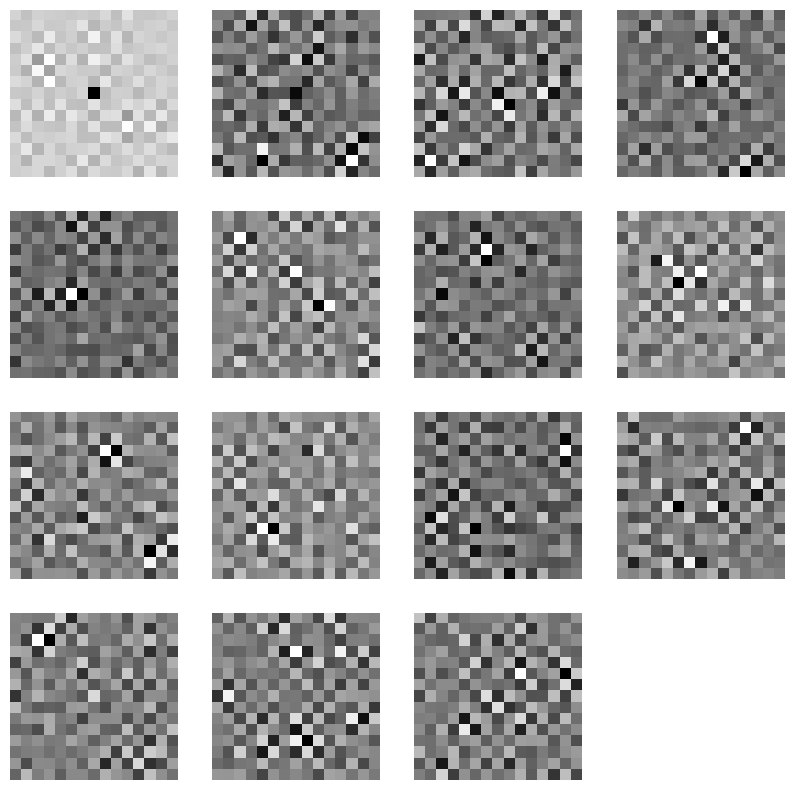

In [26]:
fig=plt.figure(figsize=(10,10))
for i in range(len(W_LDA)):
    fig.add_subplot(4, 4, i + 1)
    plt.axis('off')
    plt.imshow(W_LDA.iloc[i, :].values.reshape(2 * d + 1, 2 * d + 1), cmap = 'gray')

From this image it is clear that for most directions the pixel intensity of the original pixel has the largest impact.

### Scoring functions as  canonical texture shapes for individual classes

The scoring vectors show what are the characteristic convolution filters for different classes, i.e., what kind of shapes do we seek to label textures into classes. 

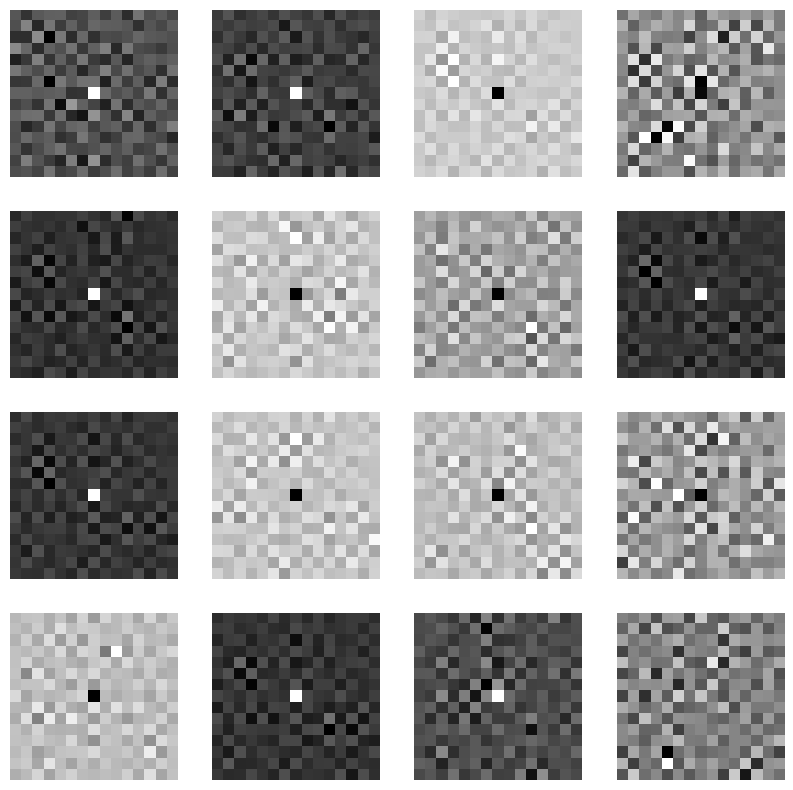

In [27]:
fig=plt.figure(figsize=(10,10))
for i in range(len(S_LDA)):
    fig.add_subplot(4, 4, i + 1)
    plt.axis('off')
    plt.imshow(S_LDA.iloc[i, :].values.reshape(2 * d + 1, 2 * d + 1), cmap = 'gray')

Again the shapes are dominated by a single center for most classes.

### How much do LDA directions fluctuate

* We can obviously ask what is the variance of individual projection directions $\xi_i$. 
* The corresponding theoretical estimates are captured by the `LDA.explained_variance_ratio_` field of the LDA object. 
* This shows only how the variance is distributed between $\boldsymbol{\xi}$ coordinates and not how much data variance it captures.
* This does not capture how much the entire LDA projection captures from the total data variance.

In [28]:
mdisplay([DataFrame(100 * lda.explained_variance_ratio_, 
                    columns = ['%'], 
                    index=['xi{:02d}'.format(i) for i in range(15)]).T],
         ['How variance is distributed'])

How variance is distributed 
 
 
 xi00 
 xi01 
 xi02 
 xi03 
 xi04 
 xi05 
 xi06 
 xi07 
 xi08 
 xi09 
 xi10 
 xi11 
 xi12 
 xi13 
 xi14 
 
 
 
 
 95.288692 
 1.236652 
 0.63519 
 0.457333 
 0.437784 
 0.366675 
 0.321546 
 0.293458 
 0.228213 
 0.216971 
 0.169189 
 0.142699 
 0.121379 
 0.049588 
 0.034631

### Variation covered by the projection vector of linear discriminant analysis

In [29]:
from scipy.linalg import orth

In [30]:
P_LDA = DataFrame(orth(W_LDA.T), 
                  index = ['x{:02d}'.format(i+1) for i in range((2*d+1)**2)], 
                  columns = ['w{:02d}'.format(i) for i in range(15)]).T
head(P_LDA)

x01       x02       x03       x04       x05       x06       x07  \
w00  0.010331 -0.023094 -0.016754  0.051815 -0.065256  0.098585 -0.003648   
w01 -0.013025  0.046387 -0.020927  0.014945 -0.041666  0.118172 -0.094190   
w02 -0.044394  0.053597  0.007879 -0.007000 -0.045996  0.036871 -0.074790   
w03 -0.088781  0.115394 -0.110427  0.068251  0.015196 -0.061147  0.009804   
w04  0.048330 -0.037616  0.004796  0.009575 -0.023832 -0.024541  0.048056   

          x08       x09       x10  ...      x216      x217      x218  \
w00 -0.044099 -0.013812  0.019180  ...  0.052620 -0.047372  0.022251   
w01  0.051495 -0.037944 -0.062597  ...  0.045216 -0.049139 -0.018554   
w02  0.012094 -0.004083  0.051047  ...  0.009128  0.024912  0.006242   
w03 -0.012800  0.009511  0.012910  ... -0.010348 -0.002122  0.055678   
w04 -0.054683  0.075467 -0.082071  ... -0.010121  0.022344  0.001071   

         x219      x220      x221      x222      x223      x224      x225  
w00 -0.069599  0.084888 -0.097794  0.110240 -0.074679  0.017404 -0.002853  
w01  0.079839 -0.119361  0.106200 -0.044558 -0.009677  0.009347  0.007530  
w02 -0.025949 -0.099441  0.076142 -0.025500  0.024868  0.050836 -0.037150  
w03 -0.032359 -0.012558 -0.008940  0.040872  0.009039 -0.044733  0.051010  
w04 -0.012810  0.095718 -0.117253  0.168960 -0.137861  0.024501 -0.014931  

[5 rows x 225 columns]

Let's compute an orthogonal projection to the linear space specified by LDA vectors. This will show how much variance LDA components can explain.

In [31]:
proj_LDA = P_LDA.T.dot(P_LDA.dot(df.iloc[:, 3:].T)).T
proj_other = df.iloc[:, 3:] - proj_LDA
head(proj_LDA)

x01       x02       x03       x04       x05       x06       x07  \
0 -0.002079  0.025493  0.000568 -0.002041 -0.015162  0.021005  0.004316   
1  0.000463  0.010981 -0.003491  0.007585 -0.005020  0.004936  0.000826   
2 -0.000983  0.005696 -0.000639  0.000253 -0.001756  0.001004  0.001631   
3 -0.000596  0.013540 -0.002534  0.002401 -0.006015  0.006520  0.001069   
4 -0.001296  0.025535  0.000145 -0.001981 -0.014096  0.022108  0.003347   

        x08       x09       x10  ...      x216      x217      x218      x219  \
0  0.011207 -0.034409  0.055992  ... -0.047721  0.041317 -0.014905  0.010468   
1  0.003320 -0.013580  0.032966  ... -0.021681  0.018896 -0.003550  0.007482   
2  0.000865 -0.005268  0.012114  ... -0.008795  0.008501 -0.002372  0.001313   
3  0.003632 -0.008524  0.023137  ... -0.022357  0.019491 -0.001670  0.006829   
4  0.014206 -0.038134  0.058831  ... -0.049211  0.041497 -0.015511  0.009980   

       x220      x221      x222      x223      x224      x225  
0 -0.001106 -0.008352  0.046212 -0.057289  0.061664 -0.018916  
1 -0.002467 -0.001031  0.016049 -0.014029  0.018517 -0.003388  
2  0.000088 -0.001332  0.008498 -0.008713  0.011001 -0.003453  
3 -0.002591 -0.002814  0.019812 -0.020037  0.022711 -0.009087  
4  0.000621 -0.010202  0.048399 -0.059731  0.066682 -0.019937  

[5 rows x 225 columns]

In [32]:
lda_var = np.var(proj_LDA, axis=0).sum()
remaining_var = np.var(proj_other, axis=0).sum()
total_var = np.var(df.iloc[:, 3:], axis=0).sum()

print('LDA variance:         {:.2f}%'.format(lda_var/total_var*100))
print('Unexplained variance {:.2f}%'.format(remaining_var/total_var*100))

LDA variance:         0.24%
Unexplained variance 99.76%


* The result clearly shows that LDA uses completely different directions than PCA and in fact most of the variance remains unexplained. 
* Thus subtle changes in the textures can lead to completely different LDA projections.

LDA chooses a projection that does not cover a lot of variance but this does not show how subtle clues LDA uses. The following visualisation shows the entire texture versus the subspace that determines all LDA coordinates $\boldsymbol{\xi}$. In this figure we show 10 random images and the corresponding LDA projection on the same scale as the original image and the normalised. Note that we cannot distinguish any textual features on the rescaled image except for the colour of the center pixel.     

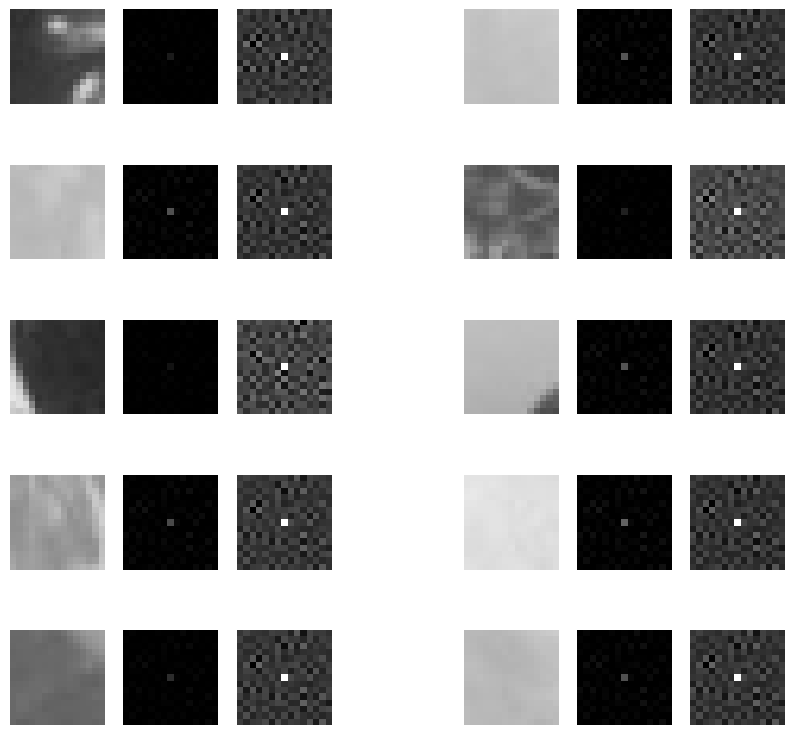

In [33]:
sdf = df.sample(10)
rdf = P_LDA.T.dot(P_LDA.dot(sdf.iloc[:, 3:].T)).T


fig=plt.figure(figsize=(10,40))
for i in range(int(len(sdf)/2)):
    fig.add_subplot(20, 7, 7 * i + 1)
    plt.axis('off')
    plt.imshow(sdf.iloc[2 * i, 3:].values.reshape(2 * d + 1, 2 * d + 1), vmin=0, vmax=1, cmap = 'gray')
    fig.add_subplot(20, 7, 7 * i + 2)
    plt.imshow(rdf.iloc[2 * i, :].values.reshape(2 * d + 1, 2 * d + 1), vmin=0, vmax=1, cmap = 'gray')
    plt.axis('off')
    fig.add_subplot(20, 7, 7 * i + 3)
    plt.imshow(rdf.iloc[2 * i, :].values.reshape(2 * d + 1, 2 * d + 1), cmap = 'gray')
    plt.axis('off')

    fig.add_subplot(20, 7, 7 * i + 5)
    plt.axis('off')
    plt.imshow(sdf.iloc[2 * i + 1, 3:].values.reshape(2 * d + 1, 2 * d + 1), vmin=0, vmax=1, cmap = 'gray')
    fig.add_subplot(20, 7, 7 * i + 6)
    plt.imshow(rdf.iloc[2 * i + 1, :].values.reshape(2 * d + 1, 2 * d + 1), vmin=0, vmax=1, cmap = 'gray')
    plt.axis('off')
    fig.add_subplot(20, 7, 7 * i + 7)
    plt.imshow(rdf.iloc[2 * i + 1, :].values.reshape(2 * d + 1, 2 * d + 1), cmap = 'gray')
    plt.axis('off')    

Formal verification that the LDA projection is correct. The result should be zero in theory but near-zero in practice.

In [34]:
lda.transform(sdf.iloc[:,3:])-lda.transform(rdf)

array([[-1.24344979e-14, -7.16093851e-15,  1.04360964e-14,
        -1.99840144e-15, -1.60982339e-15, -3.55271368e-15,
        -4.88498131e-15, -1.04360964e-14,  1.77635684e-15,
        -4.16333634e-15, -2.55351296e-15,  1.15463195e-14,
         8.88178420e-16,  3.99680289e-15,  1.77635684e-14],
       [-2.39808173e-14, -2.60902411e-15,  2.95874436e-14,
         1.91097138e-14, -1.20181642e-14,  1.40165657e-15,
        -1.72084569e-15, -1.56402669e-14, -3.85802501e-15,
        -7.54257767e-15,  1.16295862e-14,  3.73728826e-14,
        -1.12687637e-14,  2.17464935e-14,  3.29736238e-14],
       [-3.33066907e-14, -2.99760217e-15,  1.25455202e-14,
         1.31561428e-14,  6.66133815e-16,  5.00988140e-15,
        -5.96744876e-15, -1.08801856e-14,  1.11455983e-16,
        -1.08801856e-14, -6.13398221e-15,  4.28546088e-14,
        -1.66533454e-15,  1.73194792e-14,  5.77315973e-14],
       [-5.77315973e-15, -6.43929354e-15,  1.77635684e-15,
         1.23234756e-14, -7.77156117e-15,  0.00000000

# Homework

## 6.1  Predictive power of LDA projection (<font color='red'>2p</font>)  

Use `LDA.predict` function to predict class labels from texture vectors $\boldsymbol{x}_i$. Compute the corresponding confusion matrix and accuracy. How much is this result better than random? Predict class labels directly from LDA coordinates $\boldsymbol{\xi}$ by assigning the class which is closest to the class centers $(\bar{\boldsymbol{\xi}}_j)_{j=1}^{16}$. 

In [35]:
np.mean(lda.predict(df.iloc[:, 3:]) == df['label'])*100

65.25999999999999

## 6.2. Visual interpretation of LDA directions  (<font color='red'>2p</font>) 

Compute LDA coordinates $\boldsymbol{\xi}$ for reasonably sized subimages (e.g., $100\times 100$). Try to capture different textures and fruits.
You can use [`numpy.meshgrid`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) function to generate $(x,y)$ coordinates for the entire subimage. Use the existing LDA model to compute LDA coordinates for each pixel and add `luma` column. Now you have something that looks like a luma-chroma color space, except you have more dimensions. You can use some of these as substitutes for rRGB coordinates and thus you can use rgb reconstruction together with image reconstruction to see how LDA coordinates are spatially assigned and for which textures they are triggered.    

**Extra point:** Use LDA predictions to recover the color instead of true labels. Interpret results (<font color='red'>**1p**</font>).  

## 6.3 More appropriate texture generation  (<font color='red'>3p</font>) 

The main problem with our approach was very strong dependence on exact pixel intensities. The aim of this exercise is to remove the pixel intensity information. For that you need to center all textures $\boldsymbol{(x_{ij})}_{i,j=0}^{2d}$ so that the mean value $x_{00}+\ldots+x_{2d2d}=0$. 
Secondly, you can compute the average standard deviation of all coordinates

\begin{align*}
\sigma=\sqrt{\frac{\mathbf{Var}[x_{00}]+\cdots+\mathbf{Var}[x_{2d2d}]}{(2d+1)^2}}
\end{align*}

and scale the textures so that $\sigma=1$. As a result, you have effectively removed all information about the actual pixel intensities and the resulting vectors describe the textures in terms of intensity variation. Apply the entire analysis pipeline to get new LDA coordinates $\boldsymbol{\eta}$.
Visualise class separation across different directions and corresponding LDA texture masks.

**Extra points:**
* Estimate prediction precision from textures and from textures together with the pixel intensity. As usual, map to the closest cluster. (<font 
color='red'>**1p**</font>) 
* Use LDA predictions to recover the color instead of true labels. Interpret results. (<font color='red'>**1p**</font>) 
* Visualise projection coordinates $\boldsymbol{\eta}$ through RGB channels as in Exercise 5.2. (<font color='red'>**1p**</font>)

## 6.4 Targeted separation directions*  (<font color='red'>1p</font>) 

Define separating directions for a subset of clusters. Pick cluster pairs that have clearly different textures and see if the corresponding LDA shape encodes textual patterns you would expect. You need to use texture vectors that do not contain intensity information to get sensible results. 